In [1]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import interpolate
from importlib import reload
from sklearn import preprocessing
import multiprocessing as mp
from functools import partial
import scipy
import pydmd 


# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plotly
import plotly.offline as go_offline
import plotly.graph_objects as go
import plotly.express as px

# local import
sys.path.append("../")
from utils.trackmate import dataEngineering as _tm
from utils.trackmate import spatialAnalysis as _stat
from utils.trackmate import woundHealing as _wh

from utils.visualization import generalPlots
from utils.visualization import vectorPlots 
from utils.visualization import leadingEdgePlots 
from utils.visualization import densityPlots 
from utils.visualization import interactivePlots 

/home/cstansbu/.local/lib/python3.8/site-packages/libpysal/weights/util.py:23: UserWarning:

geopandas not available. Some functionality will be disabled.



# Dynamically create output folders for each input

In [2]:
DATA_NAME = 'TEST'
OUTPUT_DIR = f"{DATA_NAME}_WOUND_CLOSURE"
# DATA_PATH = '/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/WH03/outputs/D3/'
DATA_PATH = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/WH06/analysis_files/scene14/"

In [3]:
"""Create output folder for figures """

os.mkdir(OUTPUT_DIR)

In [4]:
"""Load the tracks"""


LOW_INTENSITY_THRESHOLD = 0.4

data = _tm.load_trackmate_dir(DATA_PATH)
df = _tm.merge_tracks_and_all(data)
df = _tm.clean_up_trackSpots(df, LOW_INTENSITY_THRESHOLD)
print(df.shape)

(688966, 60)


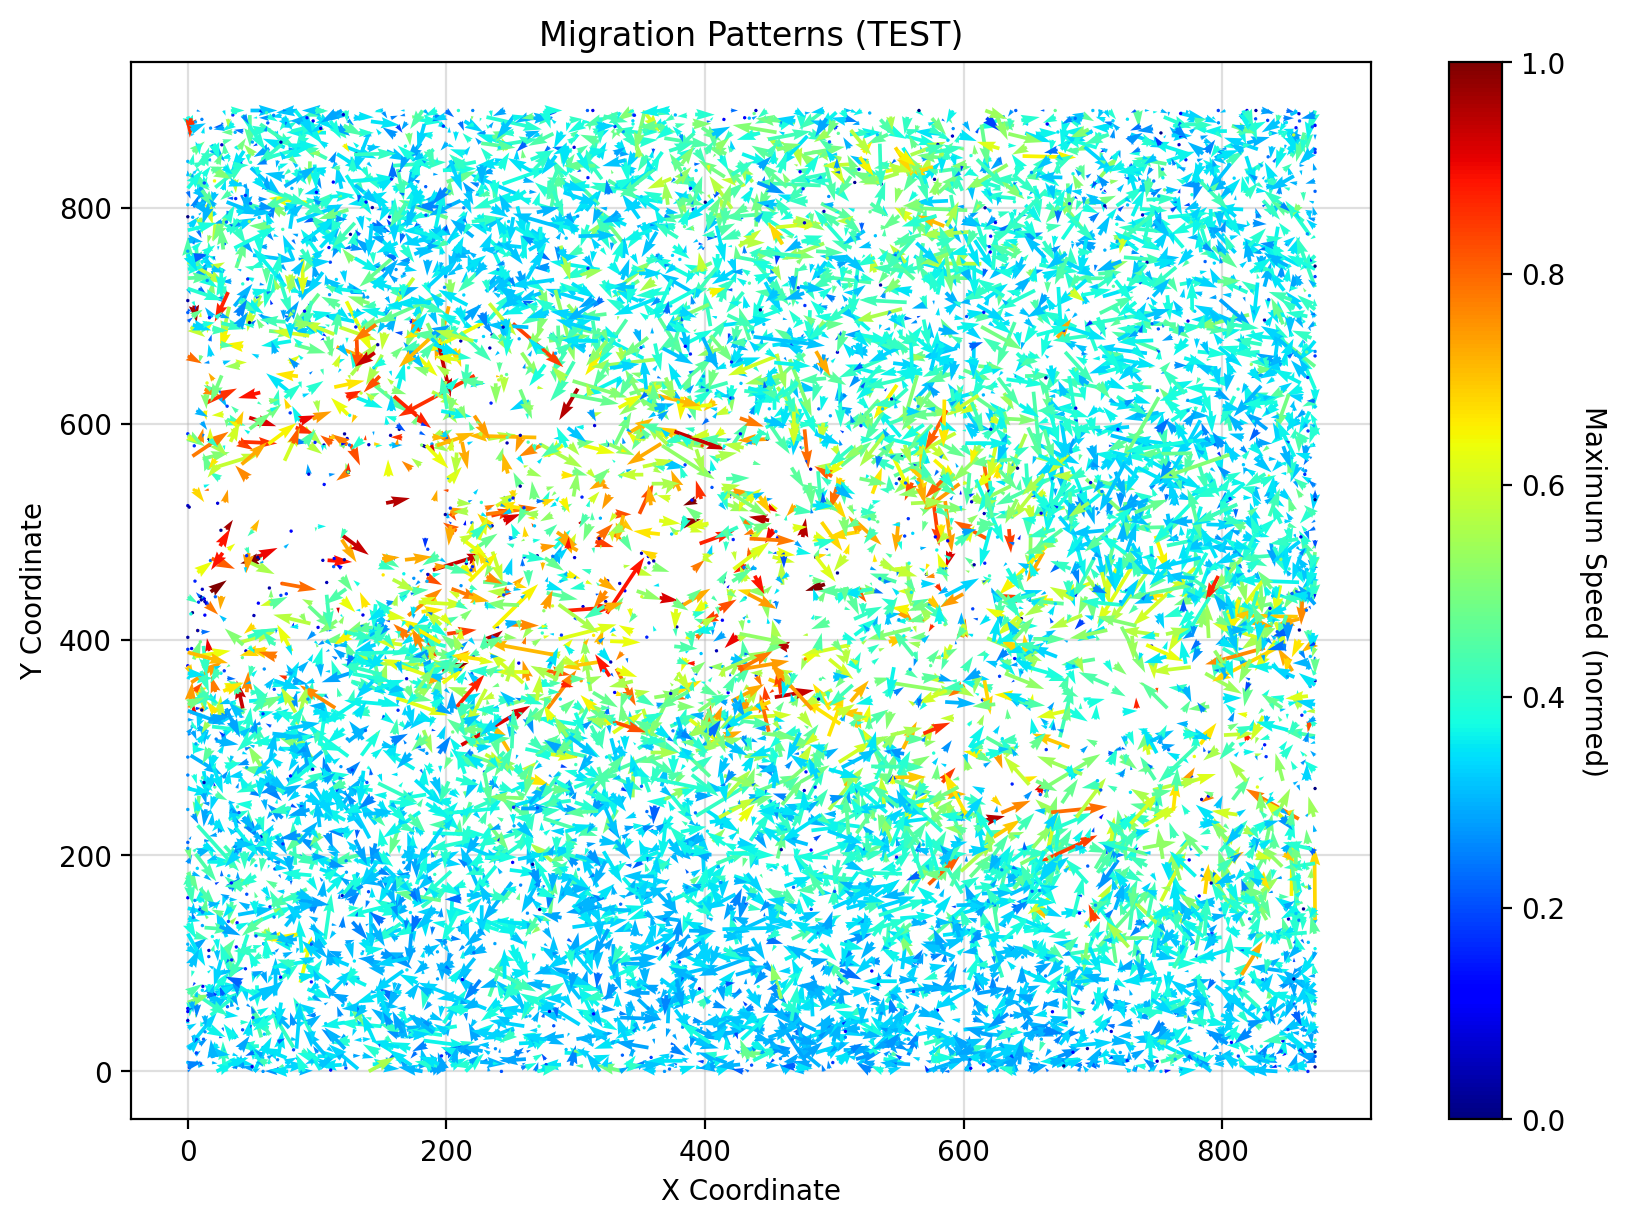

In [5]:
reload(vectorPlots)

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (10, 7)

q = vectorPlots.plot_quiver(df, 'TRACK_ID', 'TRACK_MAX_SPEED', scale=3, width=0.003)
    
cb = plt.colorbar(q, aspect=20)
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel('Maximum Speed (normed)', rotation=270)

plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.title(f"Migration Patterns ({DATA_NAME})")

plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.4)

outpath = f"{OUTPUT_DIR}/quiver_plot.png"
plt.savefig(outpath, bbox_inches='tight') 

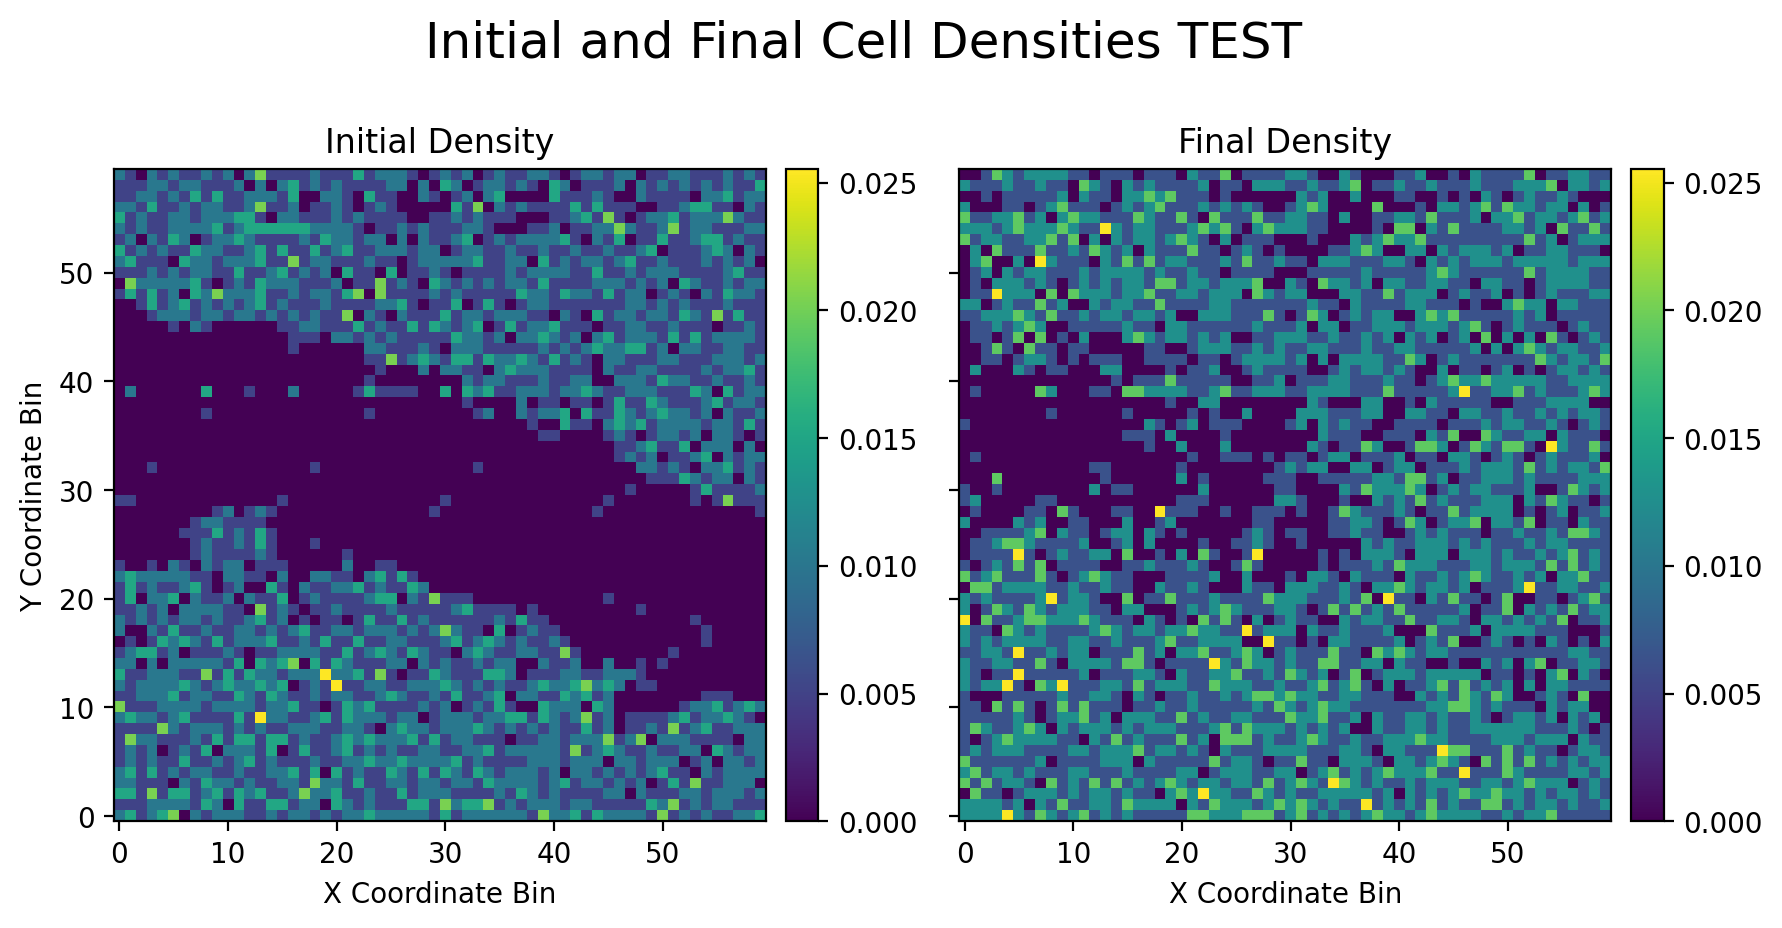

In [6]:
reload(_stat)

SIZE = 60
FRAME_SIZE = (df['POSITION_X'].max(), df['POSITION_Y'].max())

    
init = df[df['FRAME'] == df['FRAME'].min()]
final = df[df['FRAME'] == df['FRAME'].max()]

init_density, _ = _stat.get_densities(points=init[['POSITION_X', 'POSITION_Y']], 
                       frame_size=FRAME_SIZE, 
                       subregion_div=(SIZE, SIZE))

final_density, _ = _stat.get_densities(points=final[['POSITION_X', 'POSITION_Y']], 
                       frame_size=FRAME_SIZE, 
                       subregion_div=(SIZE, SIZE))

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (10, 8)
densityPlots.density_compare(init_density, final_density)

plt.suptitle(f"Initial and Final Cell Densities {DATA_NAME}", 
             fontsize=18, y=0.8)

outpath = f"{OUTPUT_DIR}/init_v_final_density.png"
plt.savefig(outpath, bbox_inches='tight') 

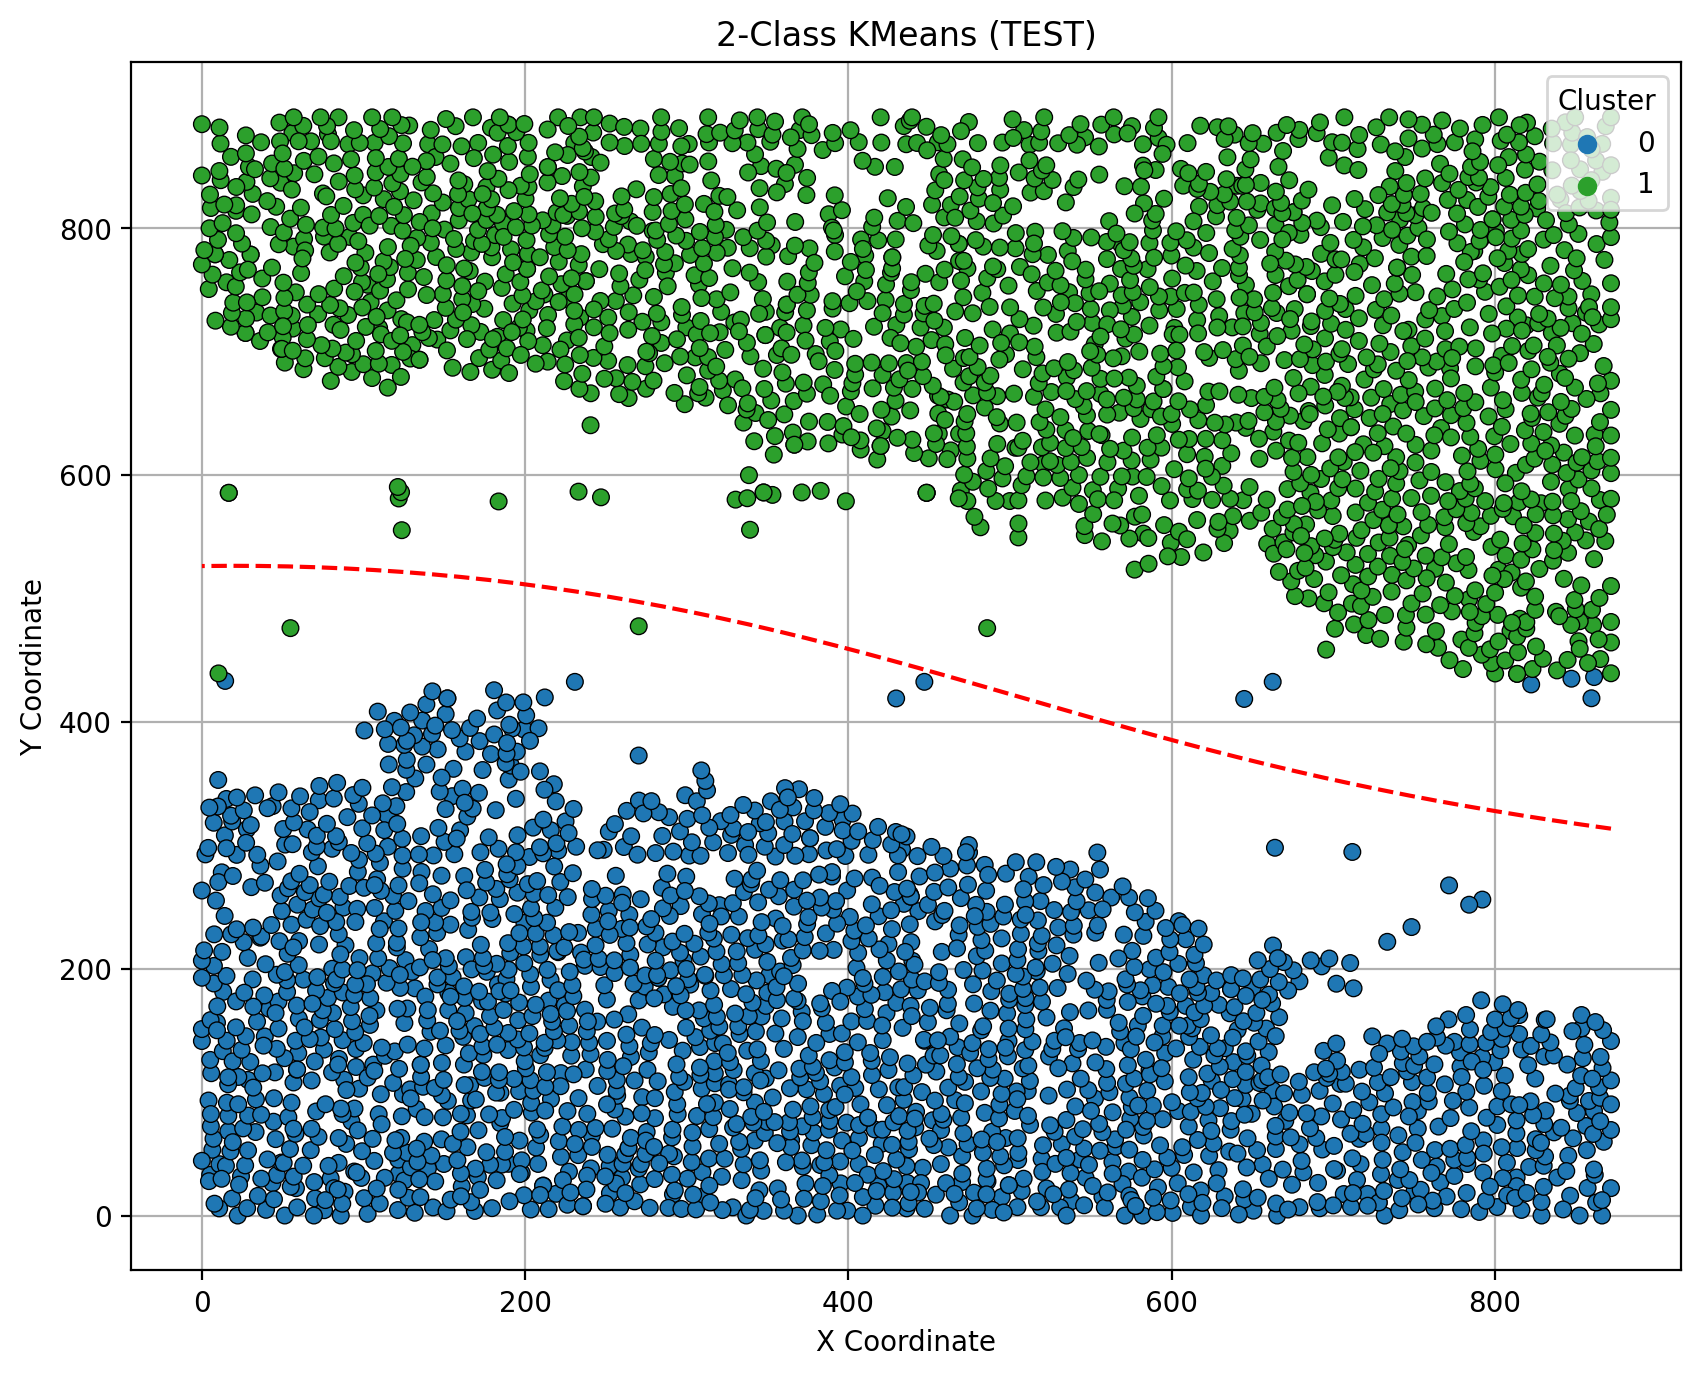

In [7]:
reload(_wh)

cut_line, t0 = _wh.estimate_cut(df, kernel='rbf', C=0.2, degree=5)

sns.scatterplot(data=t0,
                 x='POSITION_X',
                 y='POSITION_Y',
                 hue='CLUSTER',
                 palette=['C0', 'C2'],
                 edgecolor='k')

plt.plot(cut_line[:, 0], cut_line[:, 1], c='r', ls='--')


plt.legend(loc='upper right', title='Cluster')
plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.title(f"2-Class KMeans ({DATA_NAME})")
plt.gca().set_axisbelow(True)
plt.grid(True)

outpath = f"{OUTPUT_DIR}/descriminating_line.png"
plt.savefig(outpath, bbox_inches='tight') 

Text(0.5, 0, 'X Coordinate')

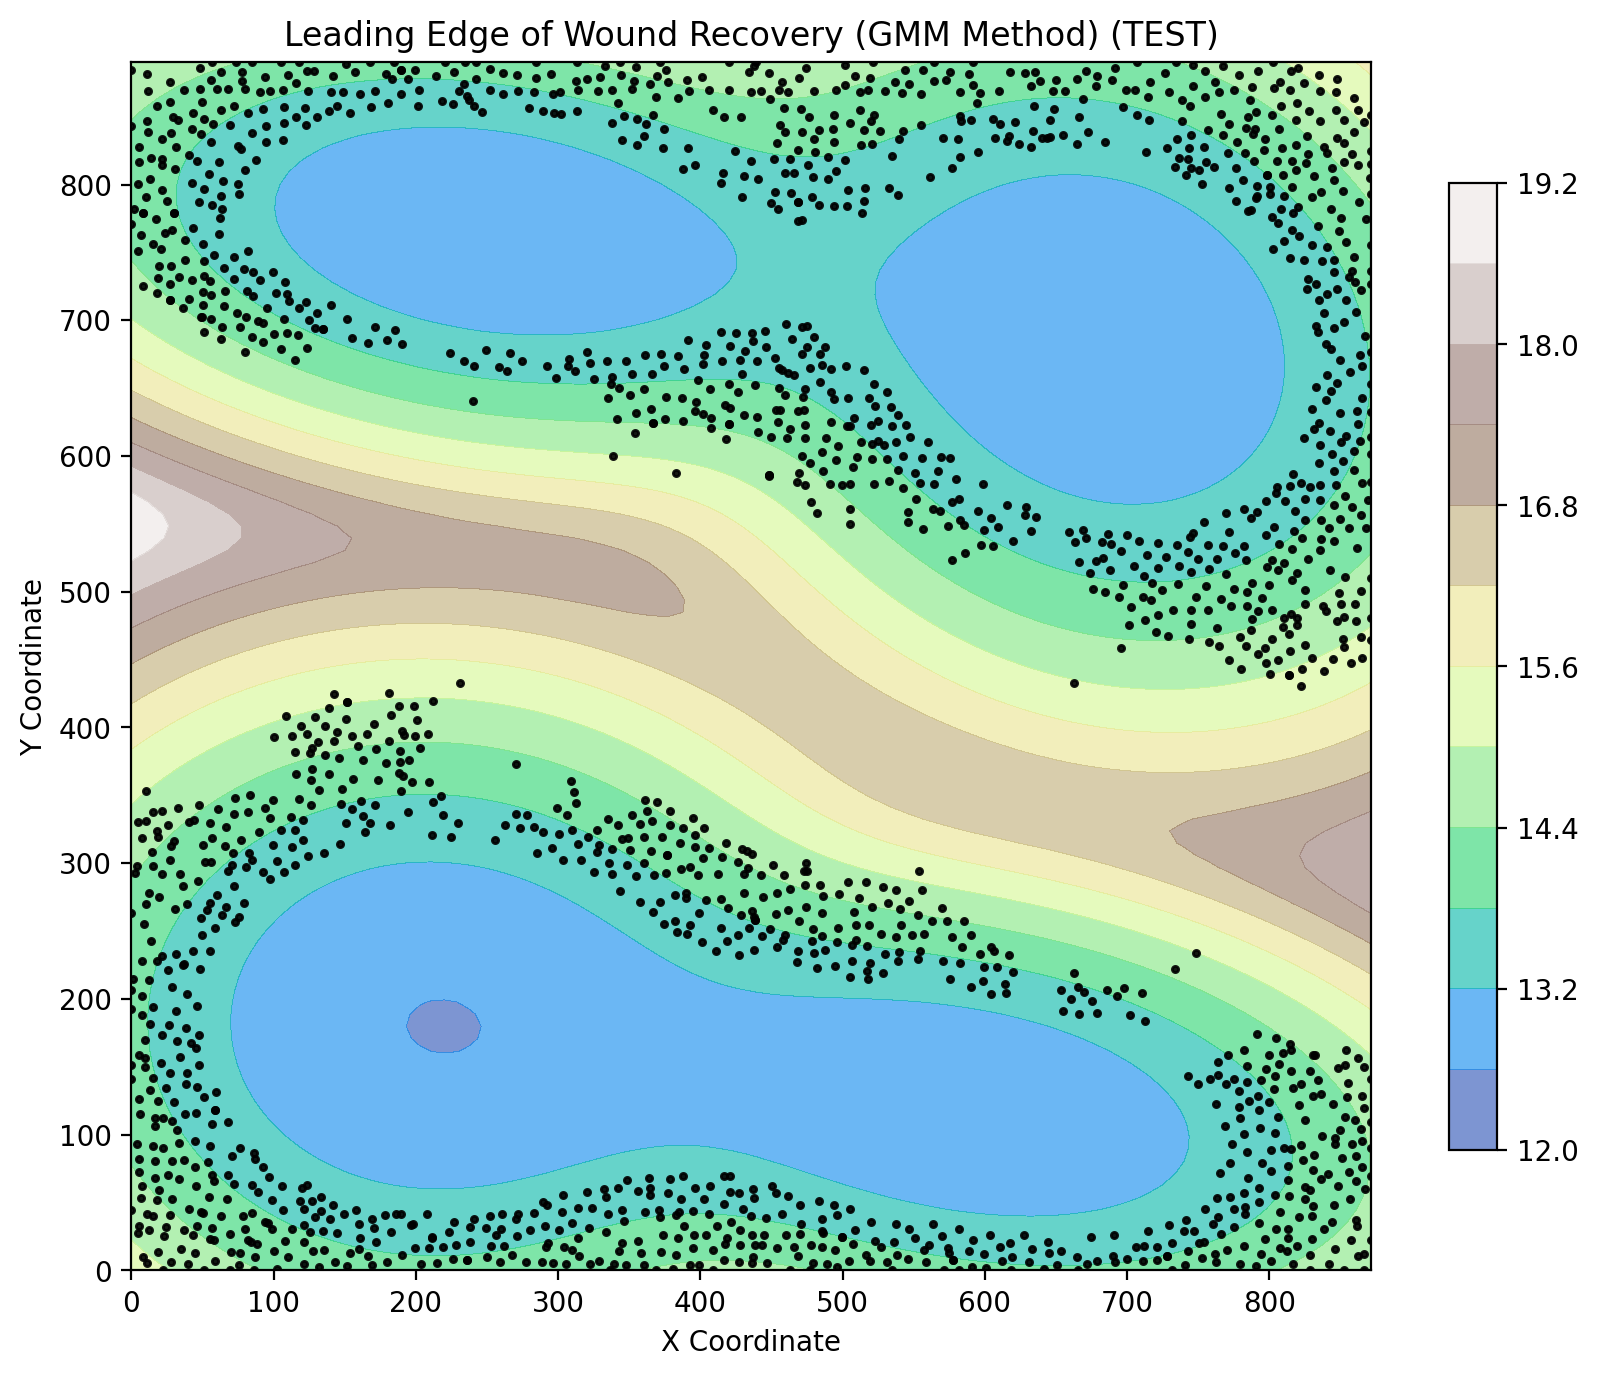

In [8]:
from sklearn import mixture
from matplotlib.colors import LogNorm


def gaussian_mixture_leading_cell_est(df, centers, n, q=0.99, d=0.5, plot=True):
    """A function to collect the cells closest to the incision line.
    
    NOTE: this assumes that the cut is essentially parallel to the x-axis
    
    
    Parameters:
    -----------------------------
        : df (pd.DataFrame): must have POSITION_X and POSITION_Y
        : centers (int): number of gaussians, should be even
        : n (int): number of countour regions
        : q (float): the quantile cut off for identiying leading cells
        : d (float): the threshold BELOW q for extracting leading cells
        : plot (bool): plot the results
        
    Returns:
    -----------------------------
        : box (pd.DataFrame): leading cells in discretized x bin regions
    """
    

    init_frame = df[df['FRAME'] == df['FRAME'].min()].reset_index()


    gmm = mixture.GaussianMixture(n_components=centers, 
                                  covariance_type='full')
    gmm.fit(init_frame[['POSITION_X', 'POSITION_Y']])

    # display predicted scores by the model as a contour plot
    x = np.linspace(init_frame['POSITION_X'].min(), 
                    init_frame['POSITION_X'].max(), num=100)
    
    y = np.linspace(init_frame['POSITION_Y'].min(),
                    init_frame['POSITION_Y'].max(), num=100)

    X, Y = np.meshgrid(x, y)

    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -gmm.score_samples(XX)
    Z = Z.reshape(X.shape)
    

    init_frame['score'] = -gmm.score_samples(init_frame[['POSITION_X', 'POSITION_Y']])
    
    upper = np.quantile(init_frame['score'], q)
    lower = np.quantile(init_frame['score'], d)
    
    tmp = init_frame[(init_frame['score'] < upper) & (init_frame['score'] > lower) ]

    CS = plt.contourf(X, Y, Z, n, cmap='terrain', alpha=0.6)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    plt.scatter(tmp['POSITION_X'], 
                tmp['POSITION_Y'], 
                s=5, 
                c='k',
                alpha=0.9)
    
    if not plot:
        plt.close()

gaussian_mixture_leading_cell_est(df, 
                                  centers=4, 
                                  n=10, 
                                  q=.99, 
                                  d=0.5, 
                                  plot=True)

plt.title(f"Leading Edge of Wound Recovery (GMM Method) ({DATA_NAME})")
plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")

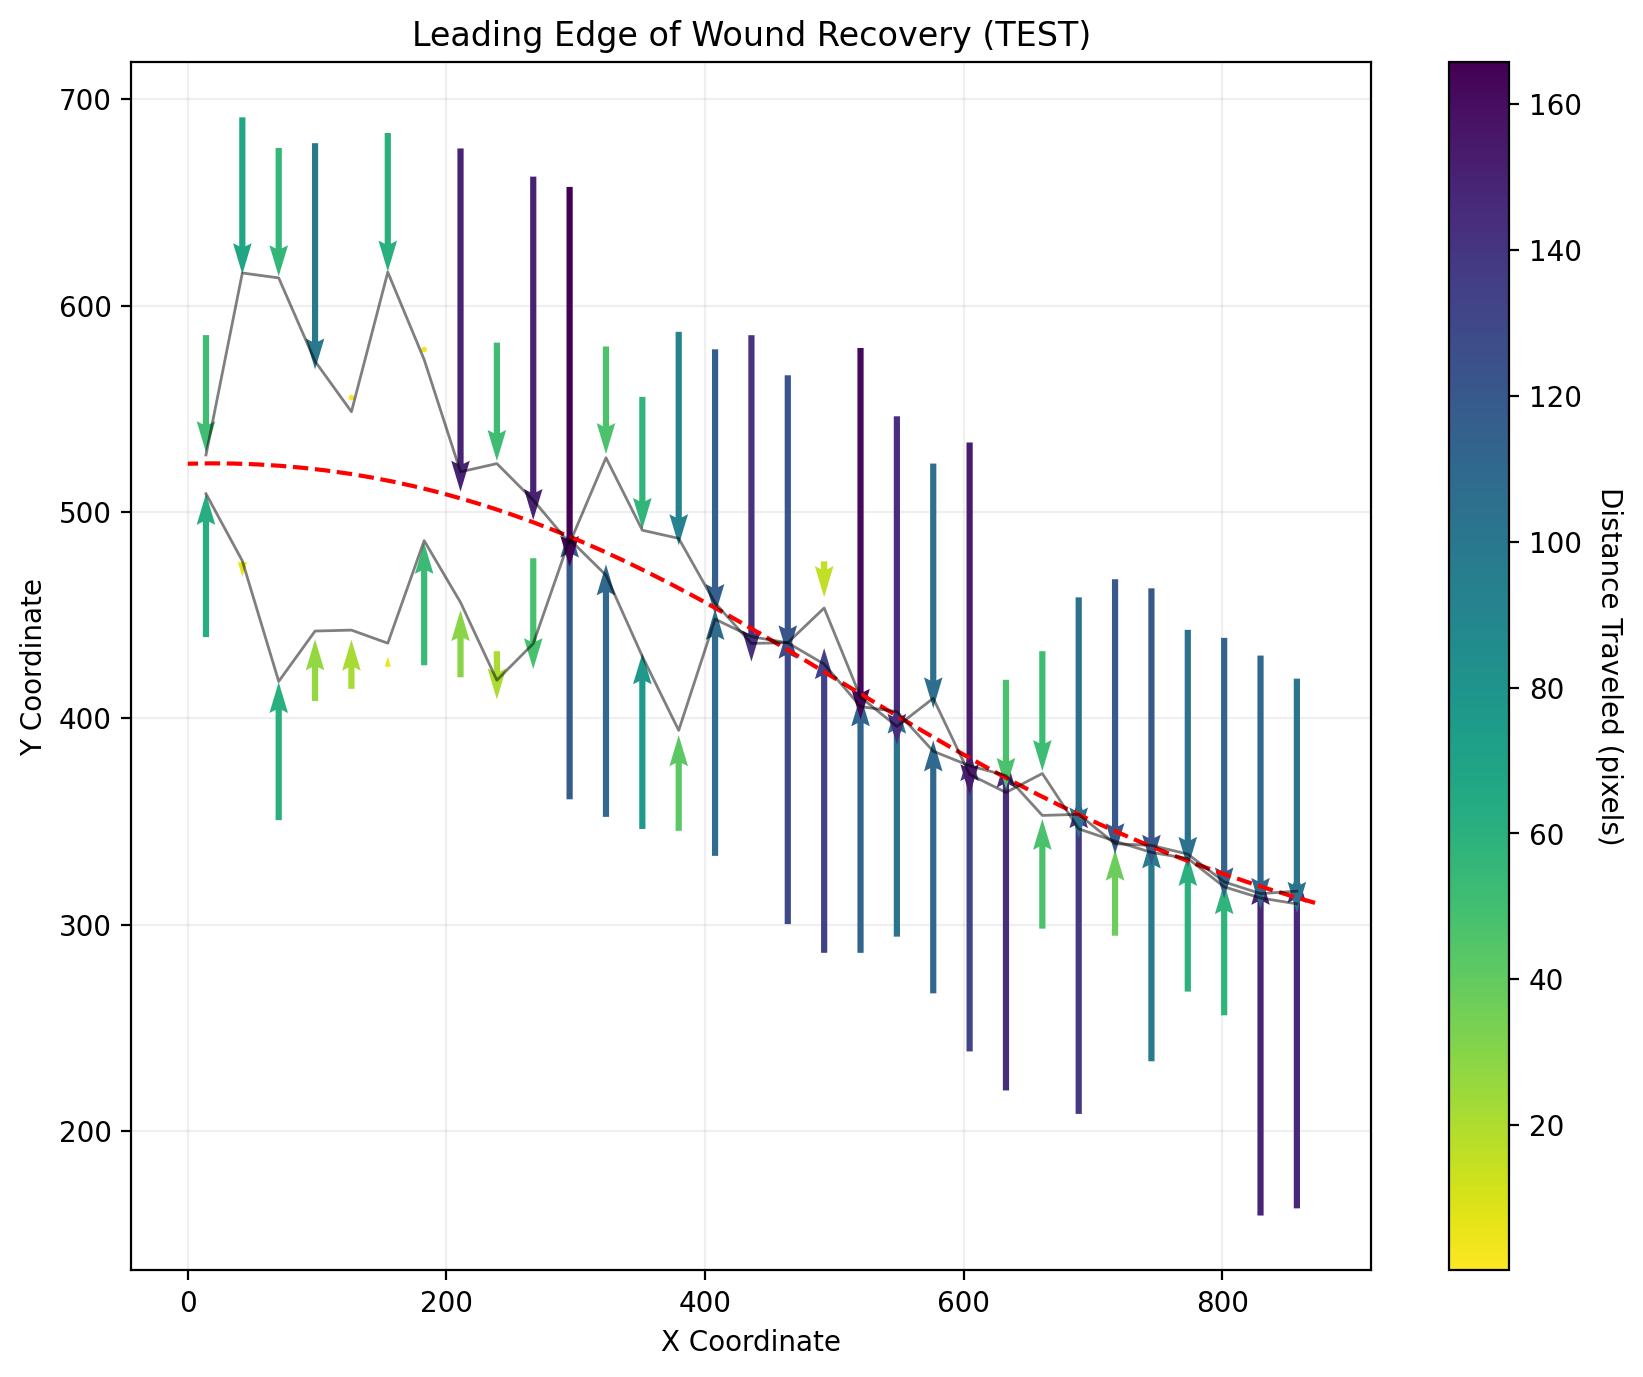

In [9]:
reload(_wh)

cmap = cm.viridis_r
n_splits = 30
cut_line, t0 = _wh.estimate_cut(df, kernel='rbf', C=0.2, degree=5)
box = _wh.get_leading_cells(df, cut_line, n_splits)
leadingEdgePlots.velocity_shark(box, cmap)


plt.plot(cut_line[:, 0], cut_line[:, 1] -3 , c='r', ls='--')

upper = box[(box['FRAME'] == (box['FRAME'].max())) & (box['type'] == 'upper')]
plt.plot(upper['POSITION_X'], 
         upper['POSITION_Y'] - 7,
         c='k',
         lw=1,
         alpha=0.5)

lower = box[(box['FRAME'] == (box['FRAME'].max())) & (box['type'] == 'lower')]
plt.plot(lower['POSITION_X'], 
         lower['POSITION_Y'] + 7,
         c='k',
         lw=1,
         alpha=0.5)

plt.title(f"Leading Edge of Wound Recovery ({DATA_NAME})")
plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.2)

outpath = f"{OUTPUT_DIR}/sharkplot_1.png"
plt.savefig(outpath, bbox_inches='tight') 

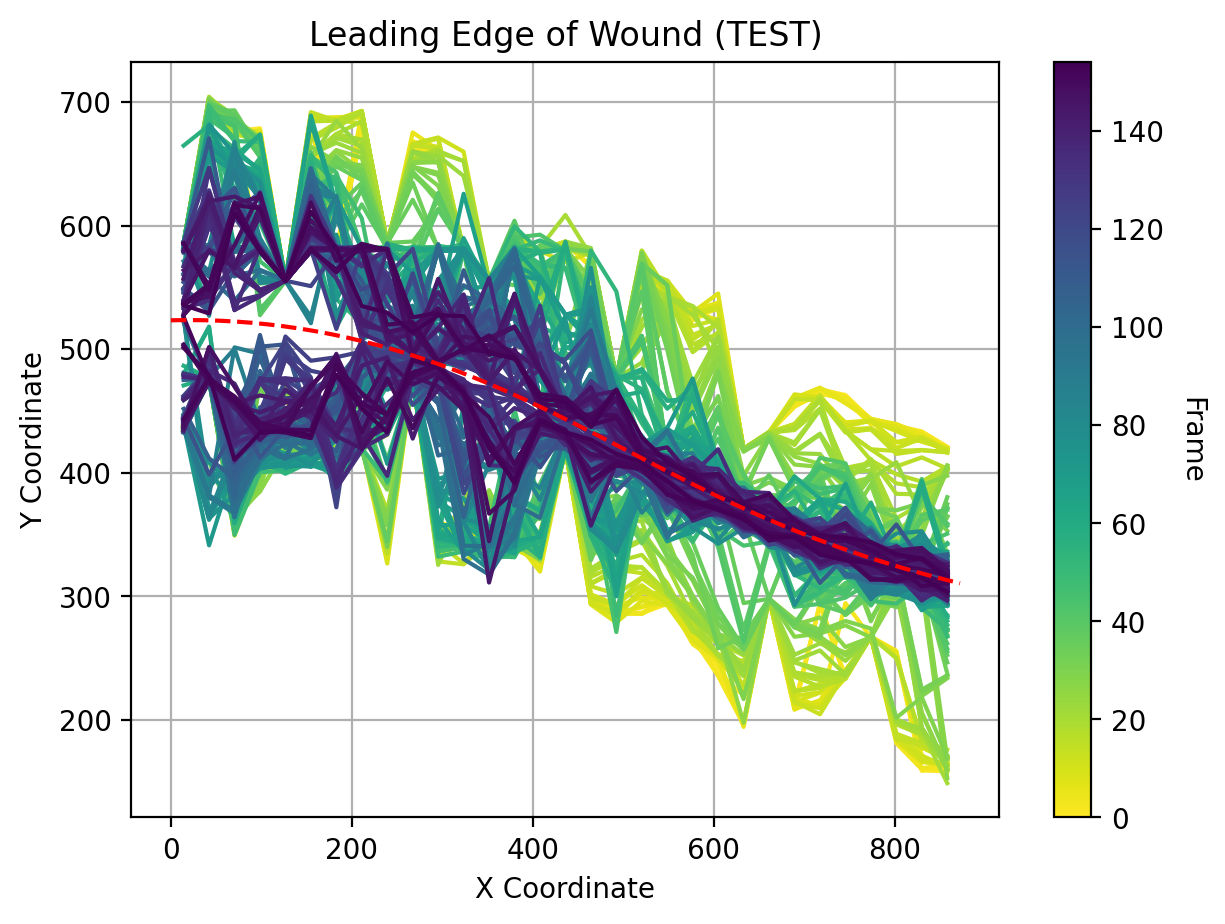

In [10]:
reload(leadingEdgePlots)

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['patch.facecolor'] = 'white'

cmap = cm.viridis_r

n_splits = 30
cut_line, t0 = _wh.estimate_cut(df, kernel='rbf', C=0.2, degree=5)
box = _wh.get_leading_cells(df, cut_line, n_splits)

leadingEdgePlots.shark_plot(box, cmap)

plt.plot(cut_line[:, 0], cut_line[:, 1] -3 , c='r', ls='--')

plt.ylabel("Y Coordinate")
plt.xlabel("X Coordinate")
plt.title(f"Leading Edge of Wound ({DATA_NAME})")
plt.gca().set_axisbelow(True)
plt.grid(True)

outpath = f"{OUTPUT_DIR}/sharkplot_2.png"
plt.savefig(outpath, bbox_inches='tight') 

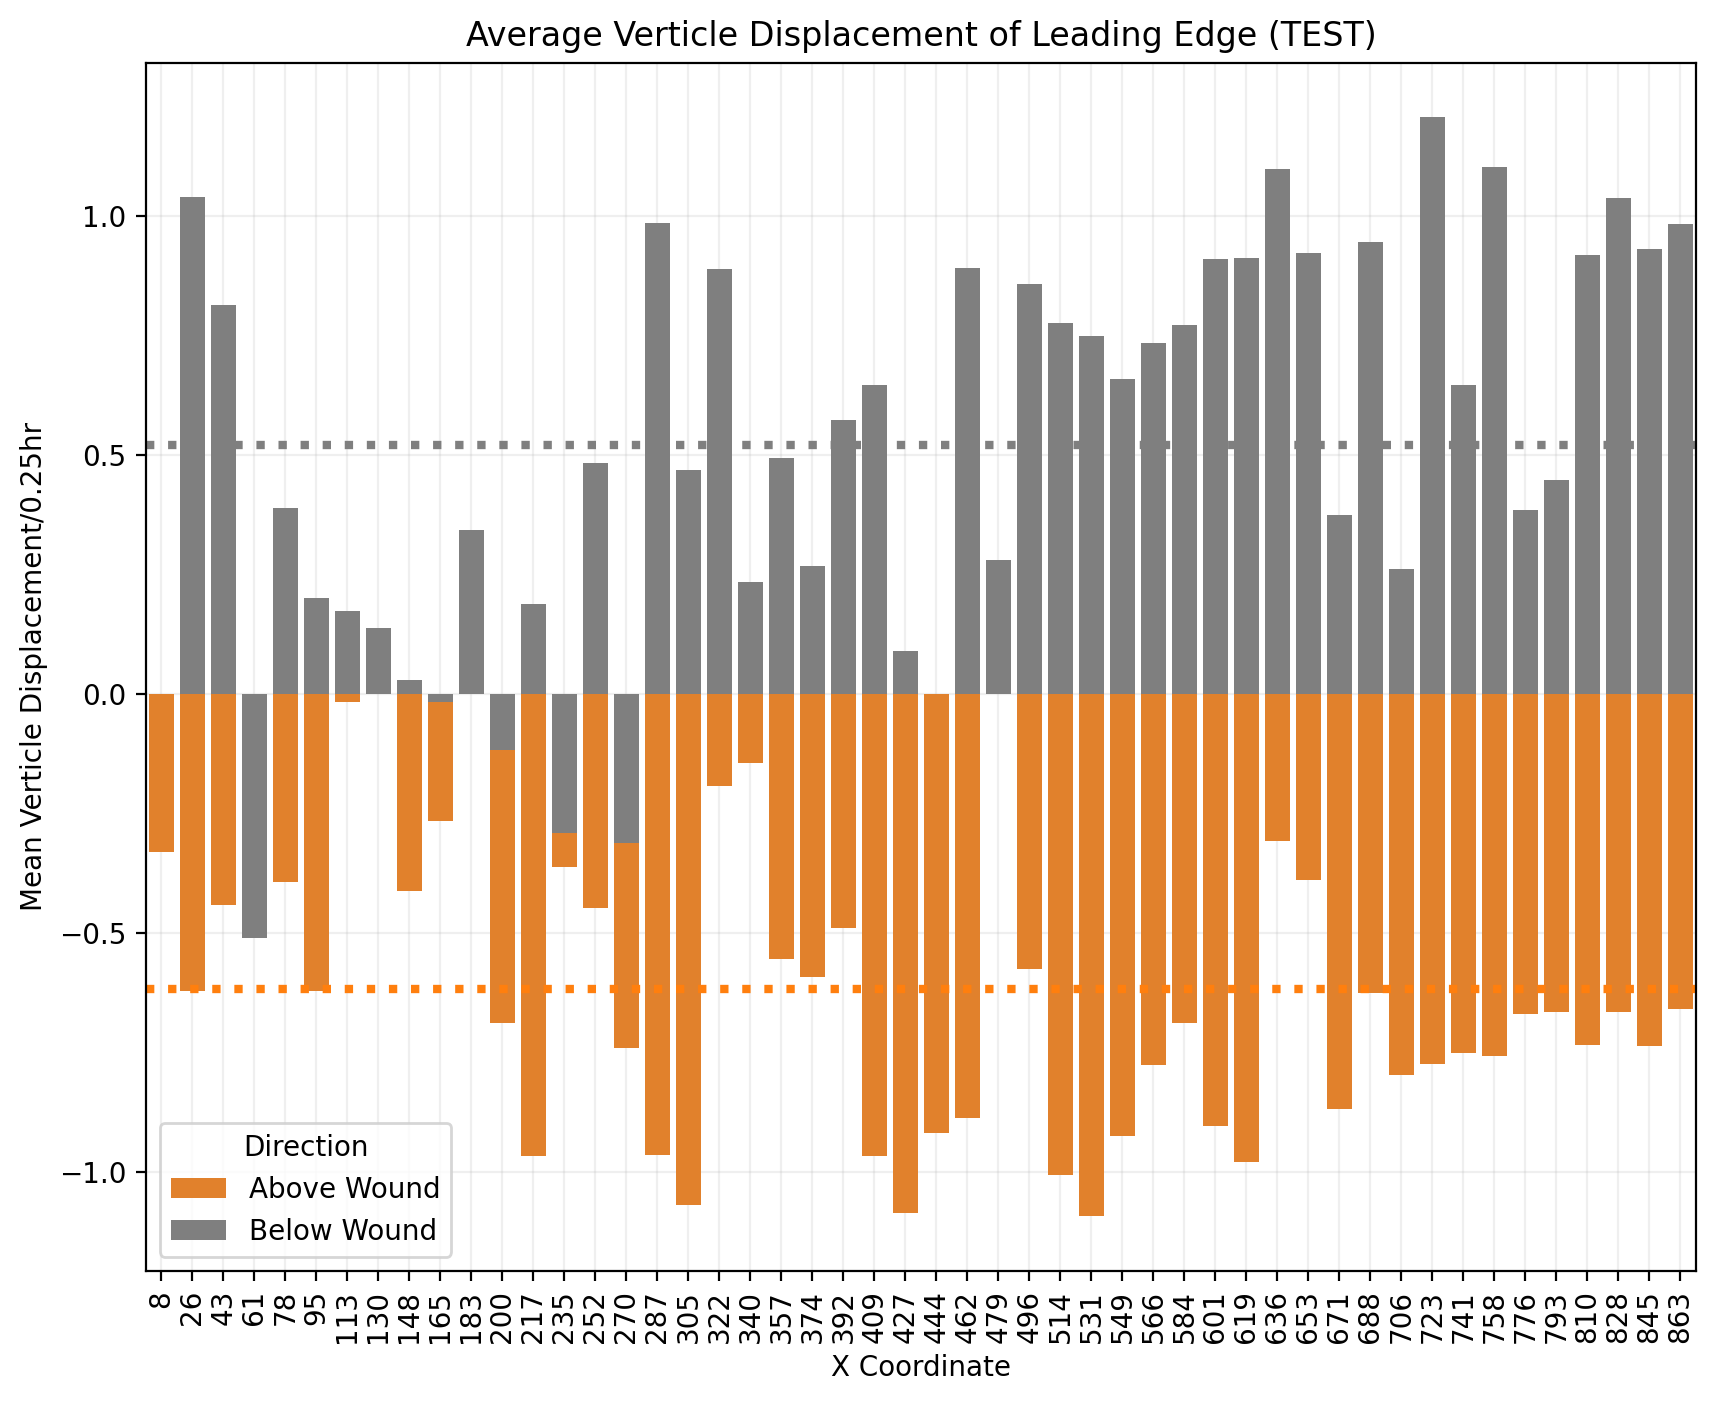

In [11]:
reload(_wh)
reload(leadingEdgePlots)

n_splits = 30
cut_line, t0 = _wh.estimate_cut(df, kernel='rbf', C=0.2, degree=5)
box = _wh.get_leading_cells(df, cut_line, n_splits)


matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (10, 8)
leadingEdgePlots.control_plot(box)

plt.xticks(rotation=90)
plt.ylabel("Mean Verticle Displacement/0.25hr")
plt.xlabel("X Coordinate")
plt.title(f"Average Verticle Displacement of Leading Edge ({DATA_NAME})")
plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.2)

outpath = f"{OUTPUT_DIR}/control_plot.png"
plt.savefig(outpath, bbox_inches='tight') 

In [24]:
reload(_wh)
n_splits = 30
cut_line, t0 = _wh.estimate_cut(df, kernel='rbf', C=0.2, degree=5)
box = _wh.get_leading_cells(df, cut_line, n_splits)
res = _wh.leading_cells_top_bottom_dist(box)
res.head()

FRAME  BOX   y_dist
0      0    1  146.347
1      0    2  215.173
2      0    3  325.757
3      0    4  262.576
4      0    5  130.624

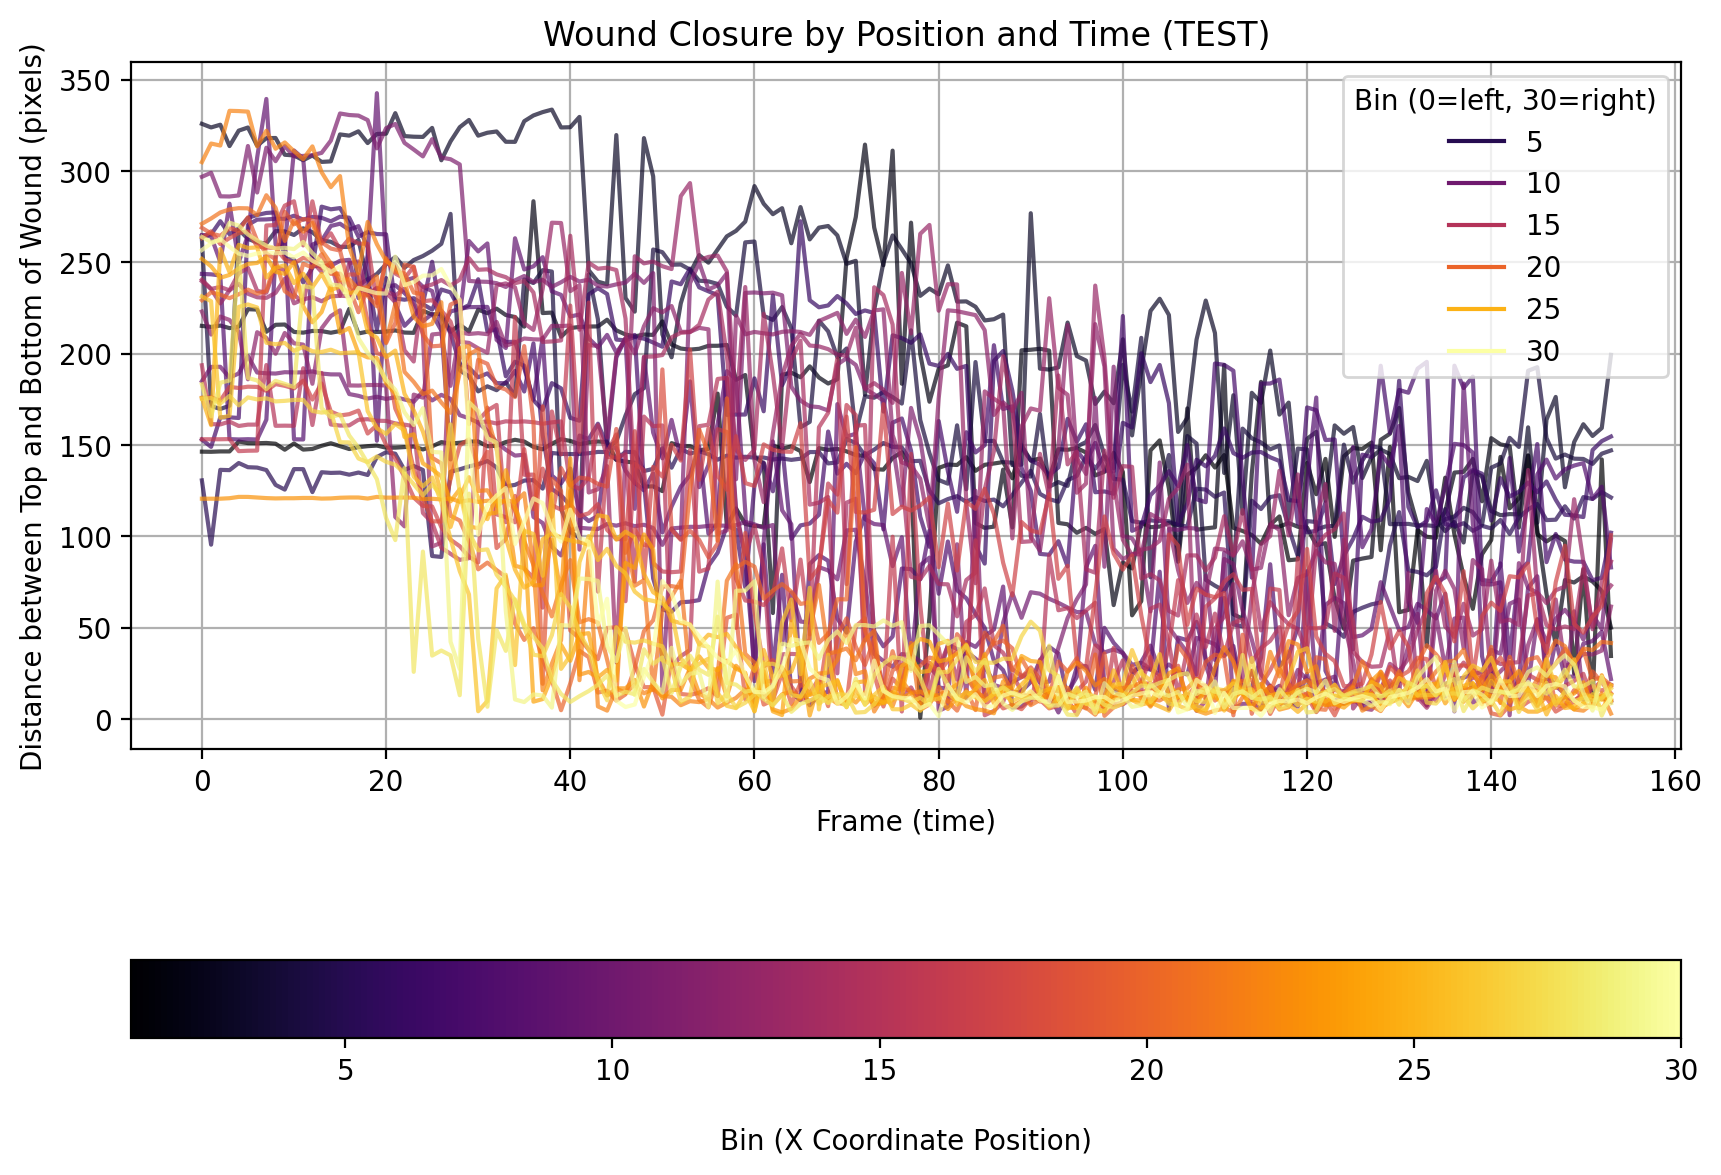

In [25]:
cmap = 'inferno'

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (10, 7)
sns.lineplot(data=res, 
                x='FRAME', 
                y='y_dist', 
                hue='BOX', 
                palette=cmap, 
                alpha=0.7)

plt.legend(loc='upper right', 
           title=f'Bin (0=left, {n_splits}=right)')

plt.ylabel("Distance between Top and Bottom of Wound (pixels)")
plt.xlabel("Frame (time)")
plt.title(f"Wound Closure by Position and Time ({DATA_NAME})")
plt.gca().set_axisbelow(True)
plt.grid(True)

sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=Normalize(vmin=res['BOX'].min(), 
                                          vmax=res['BOX'].max()))

cb = plt.colorbar(sm, aspect=20, orientation="horizontal", pad=0.2)
cb.ax.get_xaxis().labelpad = 15
cb.ax.set_xlabel('Bin (X Coordinate Position)')

outpath = f"{OUTPUT_DIR}/closure_by_position.png"
plt.savefig(outpath, bbox_inches='tight') 

Text(0.5, 1.0, 'Average Change in Wound Width by Position (TEST)')

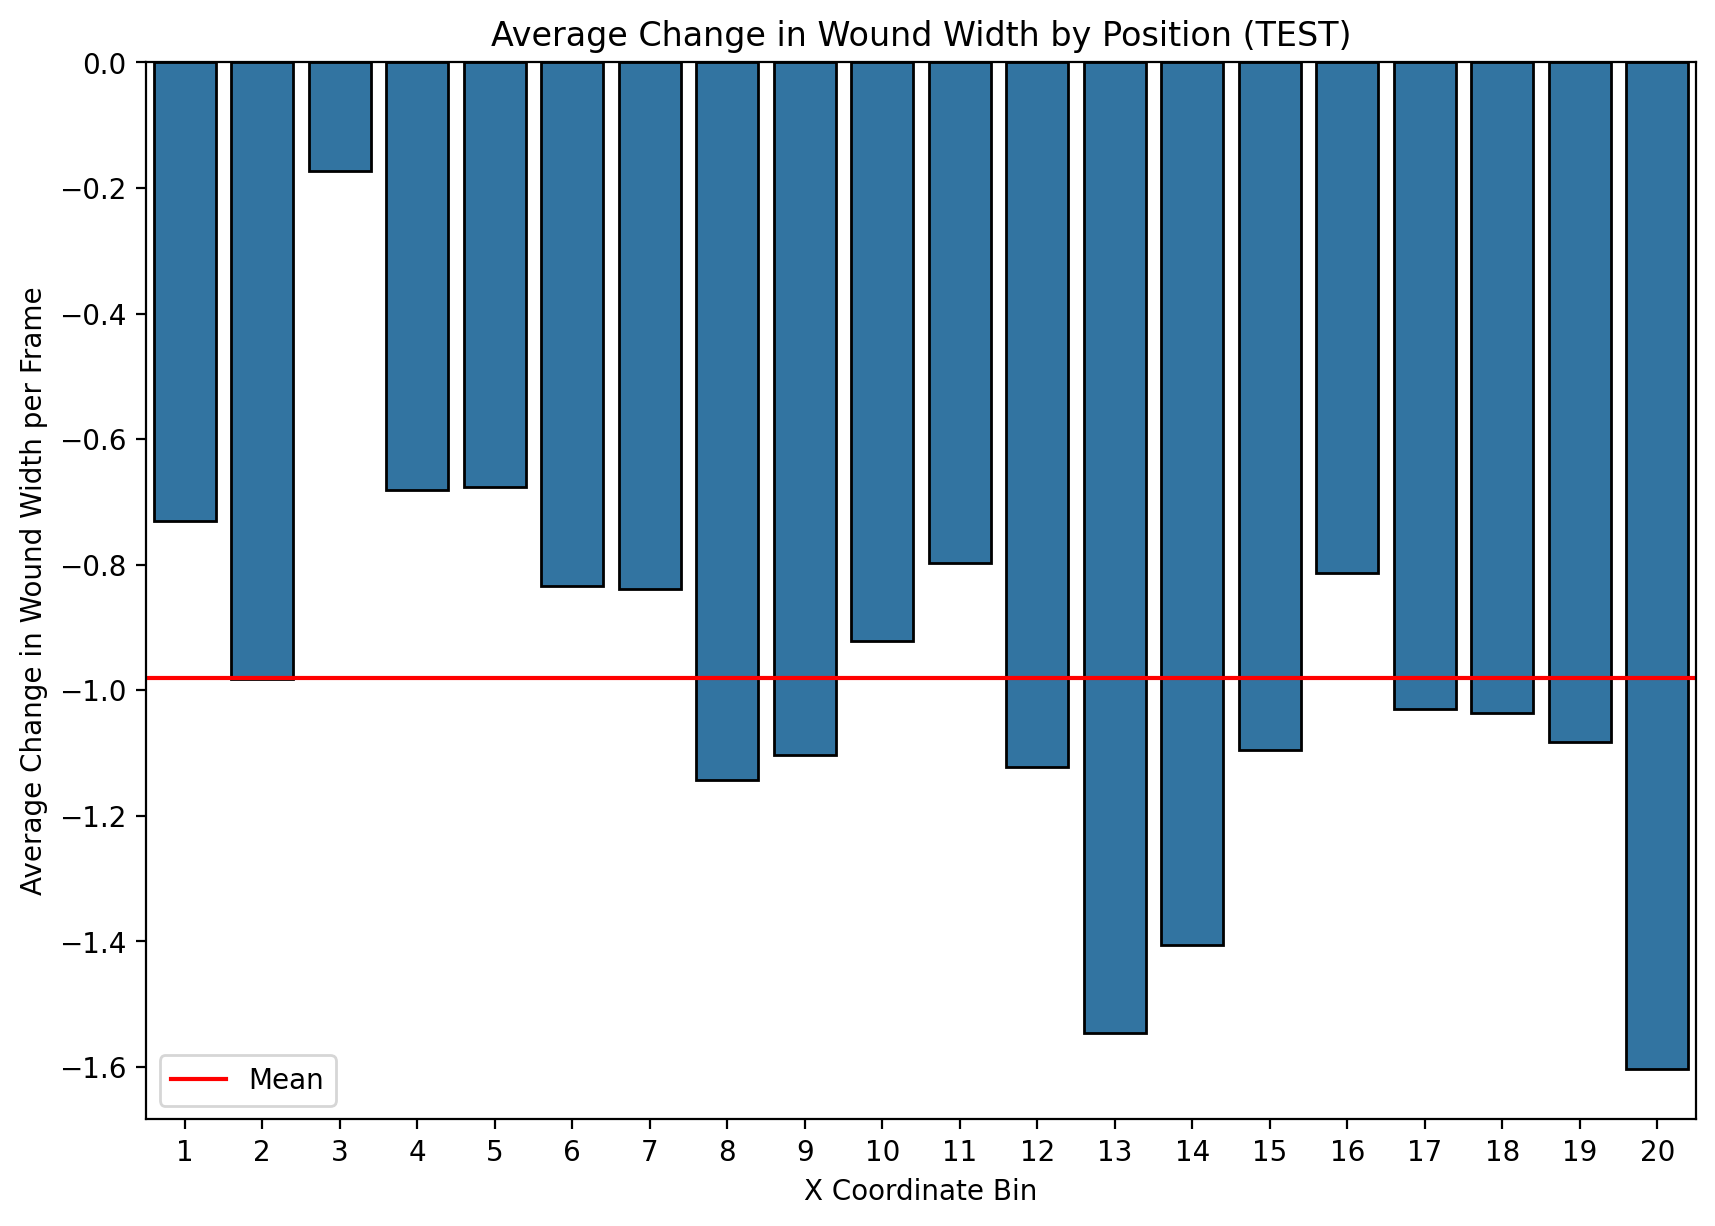

In [111]:
reload(_wh)
n_splits = 20
cut_line, t0 = _wh.estimate_cut(df, kernel='rbf', C=0.2, degree=5)
box = _wh.get_leading_cells(df, cut_line, n_splits)
res = _wh.leading_cells_top_bottom_dist(box)
res.head()

tmp = res.pivot_table(index=['FRAME'], columns='BOX')
tmp = tmp.reset_index(col_level=0)
tmp.columns = tmp.columns.droplevel().rename(None)


for col in tmp.columns[1:]:
    tmp[col] = tmp[col].diff()

tmp.rename(columns={ tmp.columns[0]: "FRAME" }, inplace = True)       
        
tmp = pd.melt(tmp, id_vars=['FRAME'], 
              var_name='BOX', 
              value_name='y_dist',
              value_vars=tmp.columns[1:])        

tmp = tmp[tmp['BOX'].notna()]

grand_mean = tmp['y_dist'].mean()

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (10, 7)
sns.barplot(data=tmp, 
            x='BOX', 
            y='y_dist',
            color="C0",
            ci=None, 
            edgecolor='k')

plt.axhline(y=grand_mean, c="r", label='Mean')
plt.legend()
plt.ylabel("Average Change in Wound Width per Frame")
plt.xlabel("X Coordinate Bin")
plt.title(f"Average Change in Wound Width by Position ({DATA_NAME})")

# 3D VIZ

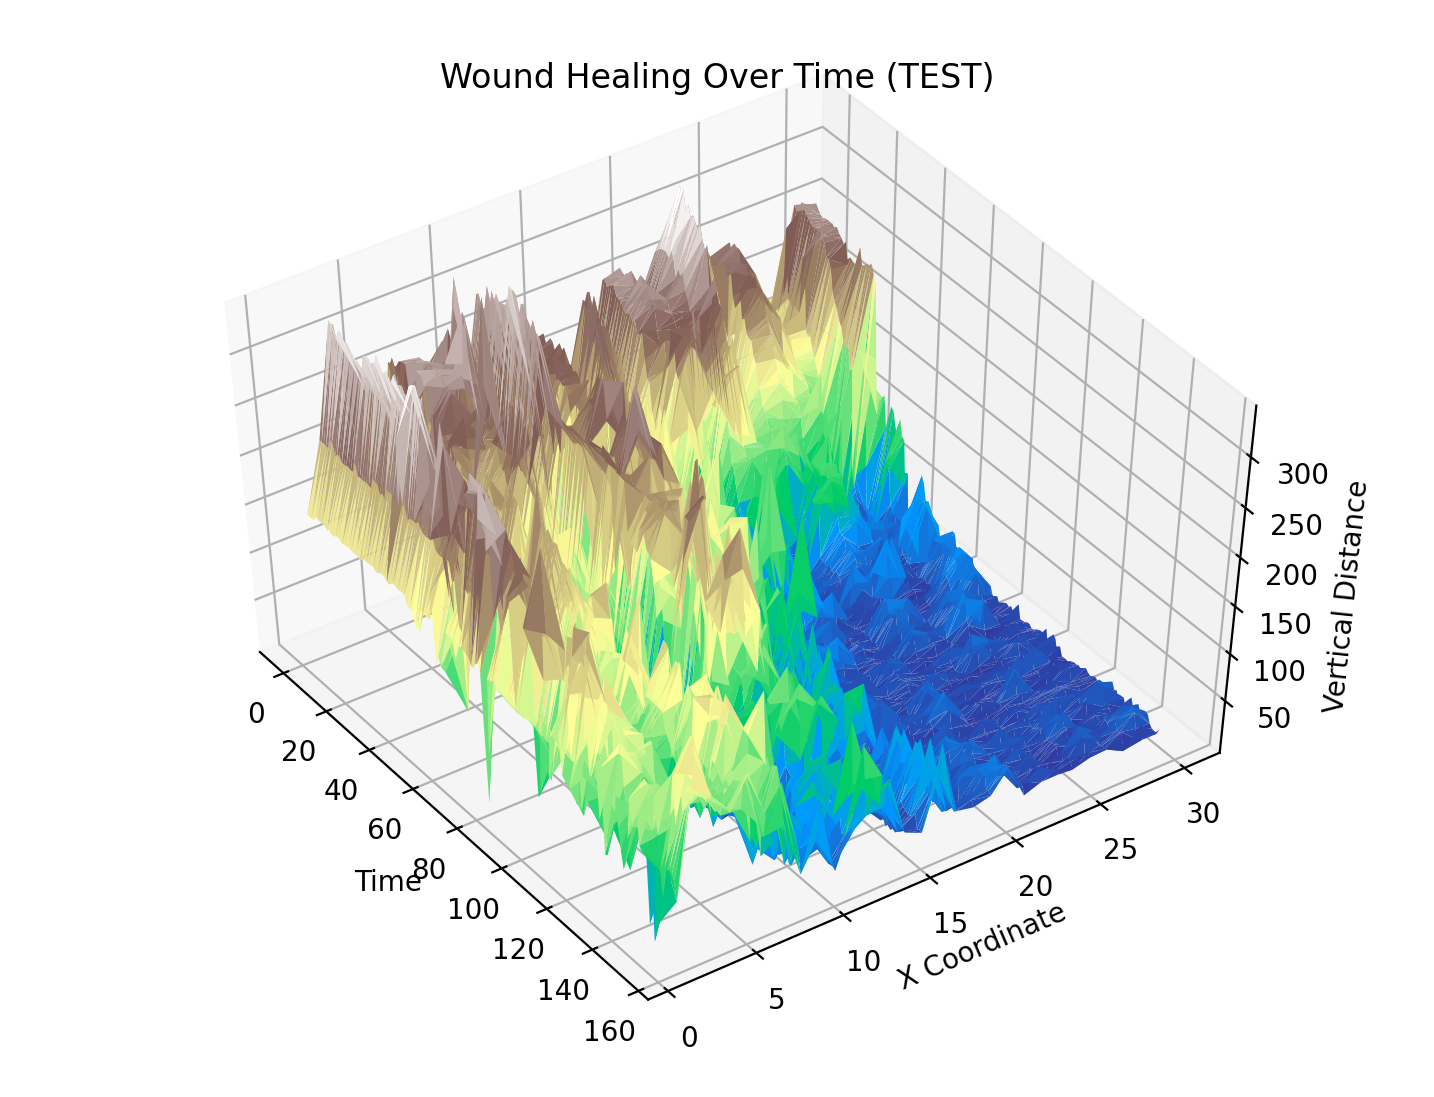

In [27]:


matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (9, 7)
ax = plt.axes(projection='3d')

ax.plot_trisurf(res['FRAME'], 
                res['BOX'], 
                res['y_dist'], 
                cmap='terrain')


ax.view_init(50, -35)
ax.dist = 11

ax.set_xlabel('Time')
ax.set_ylabel('X Coordinate')
ax.set_zlabel('Vertical Distance')
plt.title(f"Wound Healing Over Time ({DATA_NAME})")

outpath = f"{OUTPUT_DIR}/3d_closure.png"
plt.savefig(outpath, bbox_inches='tight') 

# Interpolation

In [ ]:
reload(_wh)

x =  res['FRAME'].to_numpy()
y =   res['BOX'].to_numpy()
z =  res['y_dist'].to_numpy()

x_interp, y_interp, z_interp = _wh.interpolate_3d(x, 
                                                  y, 
                                                  z,
                                                  n=100, 
                                                  r=20)
    
print("done")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-5e83766ded69>", line 7, in <module>
    x_interp, y_interp, z_interp = _wh.interpolate_3d(x,
  File "../utils/trackmate/woundHealing.py", line 128, in interpolate_3d
    z_idw = idw_npoint(x, y, z, xz, yz, 5, 1.5, r) #min. point=5, p=1.5
  File "../utils/trackmate/woundHealing.py", line 60, in idw_npoint
    if ((x[i] >= xr_min and x[i] <= xr_max) and (y[i] >= yr_min and y[i] <= yr_max)):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-5e83766ded69>", line 7, in <module>
    x_interp, y_interp, z_interp = _wh.interpolate_3d(x,
  File "../utils/trackmate/woundHealing.py", line 128, in interpolate_3d
    z_idw = idw_npoint(x, y, z, xz, yz, 5, 1.5, r) #min. point=5, p=1.5
  File "../utils/trackmate/woundHealing.py", line 60, in idw_npoint
    if ((x[i] >= xr_min and x[i] <= xr_max) and (y[i] >= yr_min and y[i] <= yr_max)):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no 

# Plotly

In [16]:
reload(interactivePlots)

outpath = f"{OUTPUT_DIR}/terrain_plot.html"

interactivePlots.plot_surface(x_interp,
                              y_interp,
                              z_interp, 
                              outpath, 
                              cmap='Inferno')

ERROR! Session/line number was not unique in database. History logging moved to new session 1198


NameError: name 'x_interp' is not defined

In [ ]:
reload(interactivePlots)

outpath = f"{OUTPUT_DIR}/contour_plot" # note - no extnsion!

interactivePlots.plot_interactive_contour(x_interp,
                                          y_interp,
                                          z_interp, 
                                          outpath, 
                                          cmap='Inferno')